In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


# Preprocessing and getting mean SER and mean Reactivation data for both stimuli

In [2]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        #y_pred, feature_importance_all = classify.log_regression_no_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        y_pred_log, feature_importance_all = classify.log_regression_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)

        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [3]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)


# SERs drift over time

In [ ]:
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import t as t_dist


def compute_drift_cosine(mean_activity, confidence=0.95, measure="distance"):
    """
    Computes a drift metric based on consecutive-trial cosine similarity.
    
    Parameters
    ----------
    mean_activity : ndarray of shape (num_trials, num_neurons)
        mean_activity[t] is the activity vector for trial t across all neurons.
    
    confidence : float, optional
        Confidence level for confidence intervals. Default is 0.95 (95% CI).
    
    measure : {'distance', 'similarity'}, optional
        Whether to return cosine distance (drift) or cosine similarity.
        - 'distance' -> 1 - cos_sim
        - 'similarity' -> cos_sim
    
    Returns
    -------
    drift_values : ndarray
        An array of length (num_trials - 1) containing the drift or similarity
        between consecutive trials.
    """

    # Number of trials
    n_trials = mean_activity.shape[0]
    
    # Compute cosine similarity for each pair of consecutive trials
    cos_sims = []
    for t in range(n_trials - 1):
        vec_t = mean_activity[t]
        vec_tp1 = mean_activity[t+1]
        
        # Safeguard against zero-norm vectors
        denom = (norm(vec_t) * norm(vec_tp1))
        if denom == 0:
            cos_sims.append(np.nan)
        else:
            cos_sim = np.dot(vec_t, vec_tp1) / denom
            cos_sims.append(cos_sim)
    
    cos_sims = np.array(cos_sims)
    
    if measure == "distance":
        # Cosine distance = 1 - cosine similarity
        drift_values = 1 - cos_sims
        y_label = "Cosine Distance (1 - cos_sim)"
        title_str = "Cosine Distance (Drift) Across Trials"
    else:
        # Directly use cosine similarity
        drift_values = cos_sims
        y_label = "Cosine Similarity"
        title_str = "Cosine Similarity Across Trials"

    # Print the drift/similarity values
    #print(f"{measure.capitalize()} values between consecutive trials:")
    #print(drift_values)

    # Prepare data for linear regression
    x = np.arange(len(drift_values)).reshape(-1, 1)
    y = drift_values

    # Fit a linear regression model
    reg_model = LinearRegression()
    reg_model.fit(x, y)
    y_trend = reg_model.predict(x)

    # Get slope, intercept, etc. via linregress
    slope, intercept, r_value, p_value, std_err = linregress(x.flatten(), y)
    print(f"Slope: {slope}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        print("The regression line significantly changes over time (p < 0.05).")
    else:
        print("The regression line does not significantly change over time (p >= 0.05).")

    # Calculate confidence intervals for the trend line
    n = len(y)
    dof = n - 2  # degrees of freedom
    t_crit = t_dist.ppf((1 + confidence) / 2, dof)  # critical t-value for given confidence level

    # Standard error of predicted values
    residuals = y - y_trend
    s_err = np.sqrt(np.sum(residuals**2) / dof)

    # Compute confidence interval for each predicted point
    x_mean = np.mean(x)
    x_var = np.sum((x.flatten() - x_mean)**2)
    ci = t_crit * s_err * np.sqrt(1/n + ((x.flatten() - x_mean)**2 / x_var))

    upper_bound = y_trend.flatten() + ci
    lower_bound = y_trend.flatten() - ci

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(drift_values, marker='o', linestyle='-', color='blue', label='Data')
    plt.plot(x.flatten(), y_trend, color='red', linestyle='--', linewidth=2, label='Trend Line')
    plt.fill_between(x.flatten(), lower_bound, upper_bound, color='red', alpha=0.2, 
                     label=f"{int(confidence * 100)}% CI")
    plt.xlabel('Consecutive trial index (t)')
    plt.ylabel(y_label)
    plt.title(title_str)
    plt.grid(True)
    plt.legend()
    plt.show()

    #return drift_values


compute_drift_cosine(mean_activity_cs_1)
compute_drift_cosine(mean_activity_cs_2)
compute_drift_cosine(mean_activity_r_1)
compute_drift_cosine(mean_activity_r_2)


# Reactivations most closely resemble the future SER

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_rel

def plot_reactivation_similarities(
    mean_activity_r, 
    trial_r, 
    mean_activity_cs, 
    name_r="Reactivations", 
    name_cs="Stimulus"
):
    """
    Compute and plot the cosine similarity of each reactivation vector to
    the previous, current, and next trial's mean activity vector, then
    run paired t-tests comparing these similarity groups.

    Parameters
    ----------
    mean_activity_r : np.ndarray
        Shape (num_reactivations, num_neurons). Each row corresponds to a
        reactivation event's mean activity across neurons.
    
    trial_r : array-like of int
        Indices mapping each reactivation (row in mean_activity_r) to a
        trial index. Must have the same length as mean_activity_r.
    
    mean_activity_cs : np.ndarray
        Shape (num_trials, num_neurons). Each row corresponds to a trial's
        mean activity across neurons (i.e., the 'stimulus' or 'trial' data).
    
    name_r : str, optional
        Label for the reactivation data (used in plot titles and print-outs).
        Default is "Reactivations".
    
    name_cs : str, optional
        Label for the trial/stimulus data. Default is "Stimulus".
    
    Returns
    -------
    similarities_df : pd.DataFrame
        A DataFrame containing:
        
        - "Reactivation Index": index of the reactivation event
        - "Trial Index": the associated trial index
        - "Similarity to Previous Trial": cosine similarity to trial-1 (NaN if none)
        - "Similarity to Current Trial": cosine similarity to trial
        - "Similarity to Next Trial": cosine similarity to trial+1 (NaN if none)
    """

    # A list to store similarity results for each reactivation
    reactivation_to_trial_similarities = []

    # Iterate through each reactivation
    for r_idx, reactivation_vector in enumerate(mean_activity_r):
        # The trial index associated with this reactivation
        trial_idx = trial_r[r_idx]

        # Get the mean activity of the previous trial if it exists
        if trial_idx > 0:
            previous_trial_mean = mean_activity_cs[trial_idx - 1]
        else:
            previous_trial_mean = None

        # Mean activity of the current trial
        current_trial_mean = mean_activity_cs[trial_idx]

        # Mean activity of the next trial if it exists
        if trial_idx < len(mean_activity_cs) - 1:
            next_trial_mean = mean_activity_cs[trial_idx + 1]
        else:
            next_trial_mean = None

        # Compute cosine similarities, handling cases where prev/next trial might not exist
        sim_prev = (cosine_similarity(
                        reactivation_vector.reshape(1, -1), 
                        previous_trial_mean.reshape(1, -1)
                    )[0, 0] if previous_trial_mean is not None else np.nan)
        
        sim_curr = cosine_similarity(
                       reactivation_vector.reshape(1, -1), 
                       current_trial_mean.reshape(1, -1)
                   )[0, 0]

        sim_next = (cosine_similarity(
                        reactivation_vector.reshape(1, -1), 
                        next_trial_mean.reshape(1, -1)
                    )[0, 0] if next_trial_mean is not None else np.nan)

        # Store the results in a dictionary
        similarities = {
            "Reactivation Index": r_idx,
            "Trial Index": trial_idx,
            "Similarity to Previous Trial": sim_prev,
            "Similarity to Current Trial": sim_curr,
            "Similarity to Next Trial": sim_next
        }
        reactivation_to_trial_similarities.append(similarities)

    # Convert the list of dictionaries to a DataFrame
    similarities_df = pd.DataFrame(reactivation_to_trial_similarities)

    # --- OPTIONAL ---
    # If you need to drop the first row (for example, if reactivation index 0 is invalid):
    # similarities_df = similarities_df.drop(index=0).reset_index(drop=True)

    # ---- PAIRED T-TESTS ----
    # Drop rows with NaNs in pairs so that the same indices are used for each pairwise comparison.
    curr_prev_df = similarities_df.dropna(
        subset=["Similarity to Current Trial", "Similarity to Previous Trial"]
    )
    curr_next_df = similarities_df.dropna(
        subset=["Similarity to Current Trial", "Similarity to Next Trial"]
    )
    prev_next_df = similarities_df.dropna(
        subset=["Similarity to Previous Trial", "Similarity to Next Trial"]
    )

    # Perform the paired t-tests
    current_vs_previous = ttest_rel(
        curr_prev_df["Similarity to Current Trial"],
        curr_prev_df["Similarity to Previous Trial"]
    )
    current_vs_next = ttest_rel(
        curr_next_df["Similarity to Current Trial"],
        curr_next_df["Similarity to Next Trial"]
    )
    previous_vs_next = ttest_rel(
        prev_next_df["Similarity to Previous Trial"],
        prev_next_df["Similarity to Next Trial"]
    )

    # Print T-test results
    print(f"T-test ({name_r} & {name_cs}): Current vs Previous Trial Similarities: {current_vs_previous}")
    print(f"T-test ({name_r} & {name_cs}): Current vs Next Trial Similarities: {current_vs_next}")
    print(f"T-test ({name_r} & {name_cs}): Previous vs Next Trial Similarities: {previous_vs_next}")

    # Display the final DataFrame
    print("\nSimilarity DataFrame:\n", similarities_df)

    # ---- PLOTTING ----
    # 1) Line plot across reactivations
    plt.figure(figsize=(12, 6))
    plt.plot(
        similarities_df["Reactivation Index"],
        similarities_df["Similarity to Previous Trial"],
        label="Similarity to Previous Trial", color="blue", alpha=0.7
    )
    plt.plot(
        similarities_df["Reactivation Index"],
        similarities_df["Similarity to Current Trial"],
        label="Similarity to Current Trial", color="green", alpha=0.7
    )
    plt.plot(
        similarities_df["Reactivation Index"],
        similarities_df["Similarity to Next Trial"],
        label="Similarity to Next Trial", color="orange", alpha=0.7
    )
    plt.xlabel("Reactivation Index")
    plt.ylabel("Cosine Similarity")
    plt.title(f"{name_r} Similarities to Neighboring {name_cs} Trials")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Box plot of the three similarity distributions
    plt.figure(figsize=(8, 6))
    # Melt the DataFrame to long form for seaborn
    melted_df = similarities_df.melt(
        id_vars=["Reactivation Index", "Trial Index"],
        value_vars=[
            "Similarity to Previous Trial",
            "Similarity to Current Trial",
            "Similarity to Next Trial",
        ],
        var_name="Trial Type",
        value_name="Cosine Similarity",
    )
    sns.boxplot(data=melted_df, x="Trial Type", y="Cosine Similarity")
    plt.title(f"Distribution of {name_r} Cosine Similarities\nto Neighboring {name_cs} Trials")
    plt.xlabel("Trial Type")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.show()

    # Return the DataFrame if further analysis or saving is required
    return similarities_df


plot_reactivation_similarities(mean_activity_r_1, trial_r_1, mean_activity_cs_1, "Reactivations Stimulus 1", "SER Stimulus 1")
plot_reactivation_similarities(mean_activity_r_2, trial_r_2, mean_activity_cs_2, "Reactivations Stimulus 2", "SER Stimulus 2")

# Predicting sign of change of SER per neuron

In [ ]:
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier


def evaluate_fold(model, X_train, X_test, y_train, y_test, test_idx):
    """Trains the model and evaluates metrics for a single CV fold.
       Also returns predictions and test indices so we can track
       which events (rows) were in this fold.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute metrics for each output (neuron)
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for neuron_idx in range(y_test.shape[1]):
        y_test_n = y_test[:, neuron_idx]
        y_pred_n = y_pred[:, neuron_idx]

        fold_accuracies.append(accuracy_score(y_test_n, y_pred_n))
        fold_precisions.append(precision_score(y_test_n, y_pred_n, zero_division=0))
        fold_recalls.append(recall_score(y_test_n, y_pred_n, zero_division=0))
        fold_f1s.append(f1_score(y_test_n, y_pred_n, zero_division=0))

    return (fold_accuracies, fold_precisions, fold_recalls, fold_f1s,
            y_test, y_pred, test_idx)


def LR_model(X_all, y_all):
    print(f"X_all shape: {X_all.shape}, y_all shape: {y_all.shape}")

    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Model initialization
    base_model = LogisticRegression(
        max_iter=1000, 
        random_state=42,
        solver="lbfgs",
        penalty="l2", 
        class_weight="balanced"
    )
    model_cv = MultiOutputClassifier(base_model)

    # Parallel cross-validation
    all_results = Parallel(n_jobs=-1)(
        delayed(evaluate_fold)(
            model_cv,
            X_all[train_idx], X_all[test_idx],
            y_all[train_idx], y_all[test_idx],
            test_idx
        )
        for train_idx, test_idx in kf.split(X_all)
    )

    # Unpack results
    (all_accuracies, all_precisions, all_recalls, all_f1s,
     all_y_test, all_y_pred, all_test_idx) = zip(*all_results)

    # Flatten or concatenate the metrics across folds
    all_accuracies = np.concatenate(all_accuracies)
    all_precisions = np.concatenate(all_precisions)
    all_recalls = np.concatenate(all_recalls)
    all_f1s = np.concatenate(all_f1s)

    for fold_idx, test_indices in enumerate(all_test_idx):
        y_pred_fold = all_y_pred[fold_idx]  # shape: (len(test_indices), n_outputs)
        y_test_fold = all_y_test[fold_idx]  # shape: (len(test_indices), n_outputs)

    # --- Summaries ---
    print("\n=== Cross-Validation Summary ===")
    print(f"Accuracy:  {np.mean(all_accuracies):.3f} ± {np.std(all_accuracies):.3f}")
    print(f"Precision: {np.mean(all_precisions):.3f}")
    print(f"Recall:    {np.mean(all_recalls):.3f}")
    print(f"F1-score:  {np.mean(all_f1s):.3f}")

    metrics_dict = {
        "Accuracy": all_accuracies,
        "Precision": all_precisions,
        "Recall": all_recalls,
        "F1": all_f1s
    }

    # Plot distributions
    plt.figure(figsize=(12, 8))
    for i, (metric_name, values) in enumerate(metrics_dict.items()):
        plt.subplot(2, 2, i+1)
        plt.hist(values, bins=100, alpha=0.7, color='b')
        plt.title(f"Distribution of {metric_name} (all folds, all neurons)")
        plt.xlabel(metric_name)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

In [ ]:
x_1 = np.diff(mean_activity_cs_1, axis= 0)
x_2 = np.diff(mean_activity_cs_2, axis=0)

X_all = np.concatenate([x_1[:-1, ], x_2[:-1, ]])
y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)
#taget SERt+1
y_all = np.concatenate([y_1[1:, ], y_2[1:, ]])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#SERt - SERt-1
LR_model(X_all, sign_changes)

In [ ]:
def compute_sign_changes(mean_activity_cs, trial_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron wrt the next SER trial.
    """
    
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_cs, axis=0)  # Shape: (trials-1, neurons)

    # Compute signs of trial differences
    trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations
    reactivation_sign_changes = trial_sign_changes[trial_r] 

    return reactivation_sign_changes

def clean_and_prepare_data(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons)
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons
    for neuron in range(mean_activity_cs_1.shape[1]):
        y_neuron = compute_sign_changes(mean_activity_cs[:, neuron], trial_r)
        y_list.append(y_neuron)

    # Prepare predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust reactivation activity by subtracting the SER activity
        X_neuron = mean_activity_r[:, neuron] - mean_activity_cs[trial_r, neuron]
        X_list.append(X_neuron)
    
    # Stack all predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all

In [ ]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_all = np.concatenate([mean_activity_r_1, mean_activity_r_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

#raw reactivation data (projected in reactivation space)
LR_model(X_all, y_all)



In [ ]:
#Ri - SERt-1 (projected in reactivation space)
X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

# Combine the datasets
X_all = np.concatenate([X_cs_1, X_cs_2])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_all.shape, y_all.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))
print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))

#Ri - SERt-1 (projected in reactivation space)
LR_model(X_all, y_all)


In [ ]:
#Ri - SERt-1 (compressed in SER space)

def mean_reactivations_by_trial(mean_activity_r, trial_r, n_trials):
   
    n_reactivations, n_neurons = mean_activity_r.shape
    
    # Accumulate sums of reactivation activity per trial
    trial_sums = np.zeros((n_trials, n_neurons), dtype=float)
    reactivation_counts = np.zeros(n_trials, dtype=int)
    
    for i in range(n_reactivations):
        trial_index = trial_r[i]
        trial_sums[trial_index] += mean_activity_r[i]
        reactivation_counts[trial_index] += 1

    # Compute mean, handling zero-reactivation trials
    trial_means = np.zeros_like(trial_sums)
    for t in range(n_trials):
        if reactivation_counts[t] > 0:
            trial_means[t] = trial_sums[t] / reactivation_counts[t]
        else:
            trial_means[t] = 0
    
    return trial_means

mean_mean_activity_r1 = mean_reactivations_by_trial(mean_activity_r_1, trial_r_1, n_trials=mean_activity_cs_1.shape[0])
print(mean_mean_activity_r1.shape)
mean_mean_activity_r2 = mean_reactivations_by_trial(mean_activity_r_2, trial_r_2, n_trials=mean_activity_cs_2.shape[0])
print(mean_mean_activity_r2.shape)

X_1 = mean_mean_activity_r1 - mean_activity_cs_1
X_2 = mean_mean_activity_r2 - mean_activity_cs_2

x_all = np.concatenate([X_1[:-1, ], X_2[:-1, ]])
print(x_all.shape)

y_1 = np.diff(mean_activity_cs_1, axis=0)
y_2 = np.diff(mean_activity_cs_2, axis=0)

y_all = np.concatenate([y_1, y_2])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#Ri - SERt-1 (compressed in SER space)
LR_model(x_all, sign_changes)



In [ ]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_cs_1_diff = np.diff(mean_activity_r_1, axis=0)
X_cs_2_diff = np.diff(mean_activity_r_2, axis=0)

X_all = np.concatenate([X_cs_1_diff, X_cs_2_diff])  # Shape: (total_reactivations -2, neurons)
y_all = np.concatenate([y_cs_1_clean[:-1, ], y_cs_2_clean[:-1, ]]) 

#Ri - Ri-1 (in reactivation space)
LR_model(X_all, y_all)

# Predicting sign of change per neuron per reactivation event

In [ ]:
X_all = np.concatenate([mean_activity_r_1[:-1, ], mean_activity_r_2[:-1, ]])
y_1 = np.diff(mean_activity_r_1, axis=0)
y_2 = np.diff(mean_activity_r_2, axis=0)
y_all = np.concatenate([y_1, y_2])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#raw Ri-1 data (in R space)
LR_model(X_all, sign_changes)

In [ ]:
x_1 = np.diff(mean_activity_r_1, axis= 0)
x_2 = np.diff(mean_activity_r_2, axis=0)

X_all = np.concatenate([x_1[:-1, ], x_2[:-1, ]])
y_1 = np.diff(mean_activity_r_1, axis=0)
y_2 = np.diff(mean_activity_r_2, axis=0)
#taget Ri+1
y_all = np.concatenate([y_1[1:, ], y_2[1:, ]])

sign_changes = np.where(y_all > 0, 1, -1)
print(sign_changes)

#Ri - Ri-1
LR_model(X_all, sign_changes)

In [ ]:
def compute_sign_changes_r(mean_activity_r):
    """
    Compute sign changes based on trial-to-trial differences and map them to reactivations.
    
    Parameters:
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - sign_changes: Array of sign changes mapped to reactivations (-1 or +1) for each neuron wrt the next SER trial.
    """
    
    # Compute trial-to-trial differences
    trial_diff = np.diff(mean_activity_r, axis=0)  # Shape: (trials-1, neurons)

    # Compute signs of trial differences
    trial_sign_changes = np.where(trial_diff > 0, 1, -1)  # Shape: (trials-1, neurons)

    # Map trial-level changes to reactivations
    #reactivation_sign_changes = trial_sign_changes[trial_r]

    return trial_sign_changes #reactivation_sign_changes

def clean_and_prepare_data_r(mean_activity_r, mean_activity_cs, trial_r):
    """
    Prepare predictors (X) and targets (y) for logistic regression
    
    Parameters:
    - mean_activity_r: Reactivation-level activity (shape: reactivations x neurons)
    - mean_activity_cs: Trial-level activity (shape: trials x neurons)
    - trial_r: Reactivation-to-trial mapping (shape: reactivations,)
    
    Returns:
    - X_all: Combined predictors (reactivation activity) for sensory evoked response (shape: total_reactivations, neurons).
    - y_all: Combined targets (sign changes) for all neurons (shape: total_reactivations, neurons).
    """
    X_list = []  # Predictors for all neurons
    y_list = []  # Targets for all neurons
    
    # Compute targets for all neurons
    for neuron in range(mean_activity_r.shape[1]):
        y_neuron = compute_sign_changes_r(mean_activity_r[:, neuron])
        y_list.append(y_neuron)

    # Prepare predictors for the subset of neurons
    for neuron in range(mean_activity_r.shape[1]):
        # Adjust SER activity by subtracting the reactivation activity
        X_neuron = mean_activity_cs[trial_r, neuron] - mean_activity_r[:, neuron]
        X_list.append(X_neuron)
    
    # Stack all predictors and targets
    X_all = np.column_stack(X_list)  # Shape: (total_reactivations, subset_neurons)
    y_all = np.column_stack(y_list)  # Shape: (total_reactivations, total_neurons)
        
    return X_all, y_all


X_cs_1, y_cs_1_clean = clean_and_prepare_data_r(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_r(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

# Combine the datasets
X_all = np.concatenate([X_cs_1[:-1, ], X_cs_2[:-1, ]])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

print(X_all.shape, y_all.shape)

# Sanity check the processed targets
unique_cs_1, counts_cs_1 = np.unique(y_cs_1_clean, return_counts=True)
unique_cs_2, counts_cs_2 = np.unique(y_cs_2_clean, return_counts=True)

print("Processed Targets for CS_1:")
print(dict(zip(unique_cs_1, counts_cs_1)))
print("\nProcessed Targets for CS_2:")
print(dict(zip(unique_cs_2, counts_cs_2)))

#SER - Ri-1 (projected in reactivation space, prediction reactivations with SER)
LR_model(X_all, y_all)

In [ ]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data_r(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_r(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_all = np.concatenate([mean_activity_cs_1[trial_r_1[:-1], ], mean_activity_cs_2[trial_r_2[:-1], ]])  # Shape: (total_reactivations, neurons)
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

#raw SER data (projected in reactivation space)
LR_model(X_all, y_all)

In [ ]:
X_cs_1, y_cs_1_clean = clean_and_prepare_data_r(mean_activity_r_1, mean_activity_cs_1, trial_r_1)
X_cs_2, y_cs_2_clean = clean_and_prepare_data_r(mean_activity_r_2, mean_activity_cs_2, trial_r_2)

X_cs_1_diff = np.diff(mean_activity_cs_1[trial_r_1, ], axis=0)
X_cs_2_diff = np.diff(mean_activity_cs_2[trial_r_2, ], axis=0)

X_all = np.concatenate([X_cs_1_diff, X_cs_2_diff]) 
y_all = np.concatenate([y_cs_1_clean, y_cs_2_clean]) 

#SERt - SERt-1 (in reactivation space)
LR_model(X_all, y_all)




# Other, distribution check

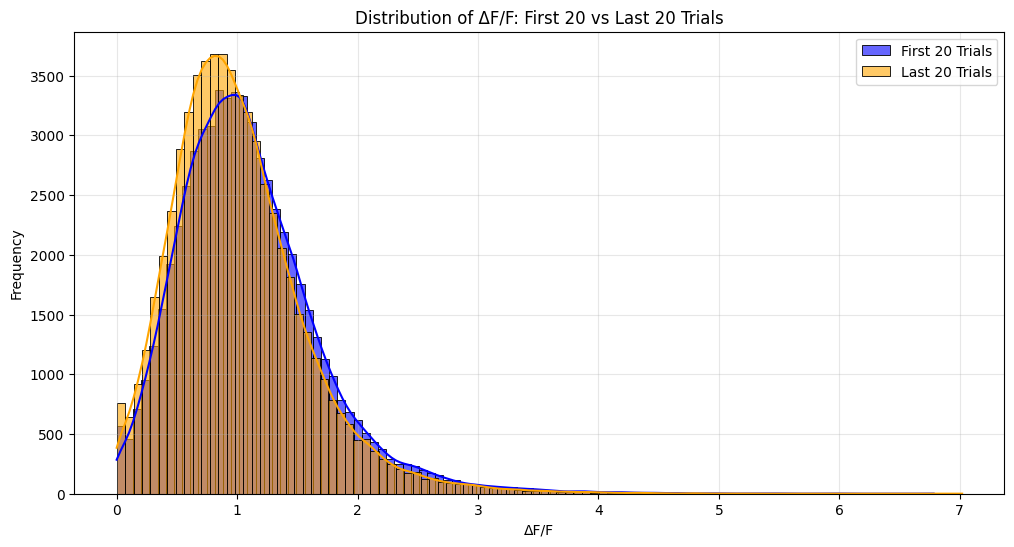

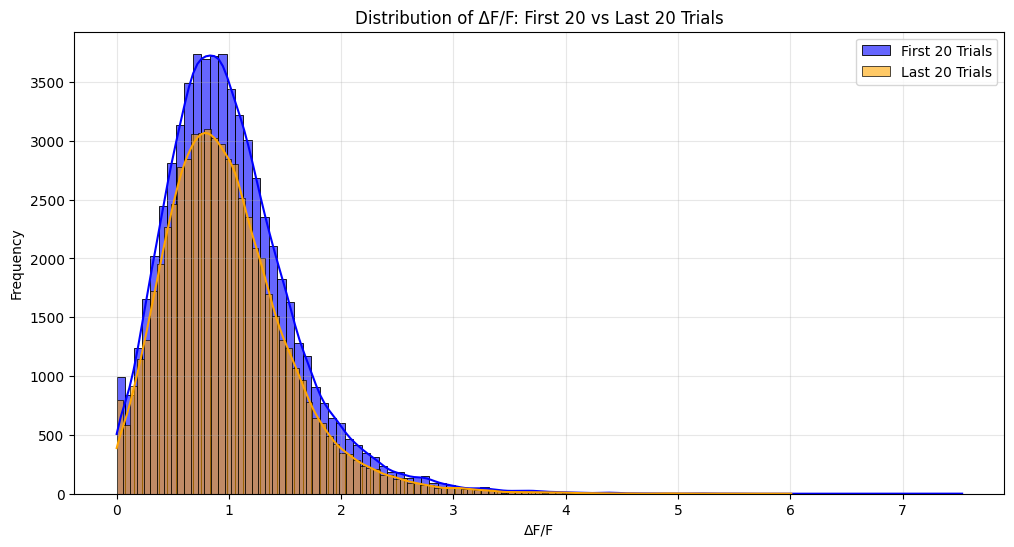

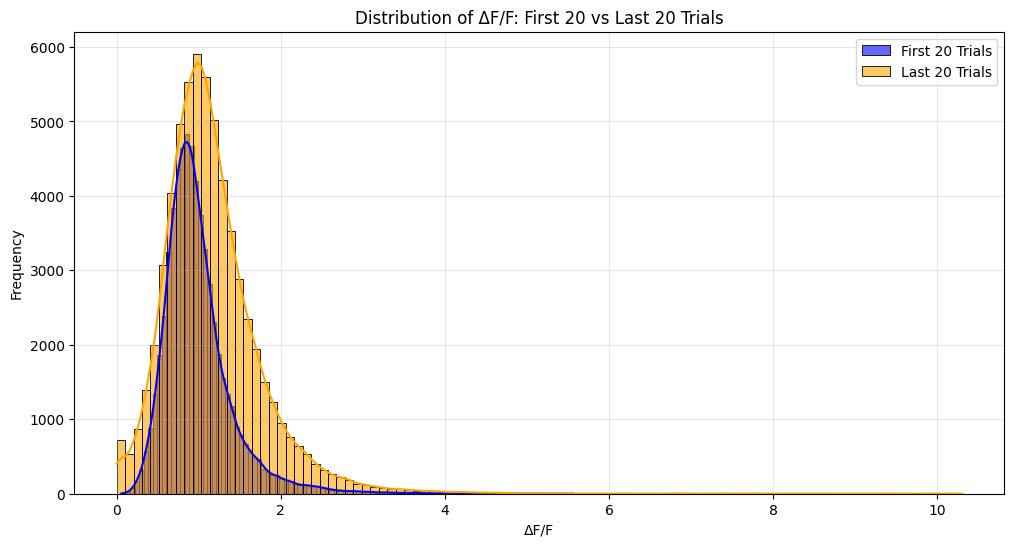

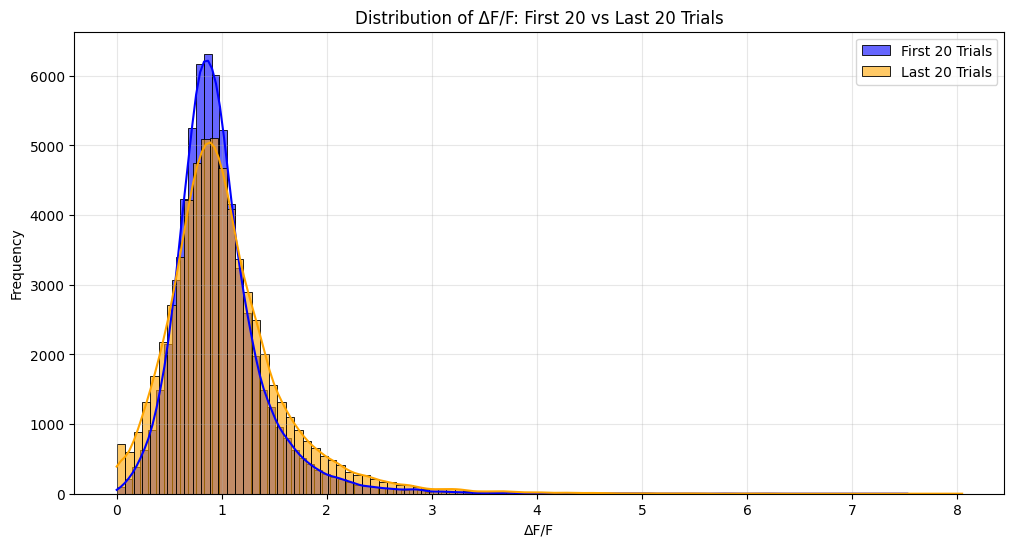

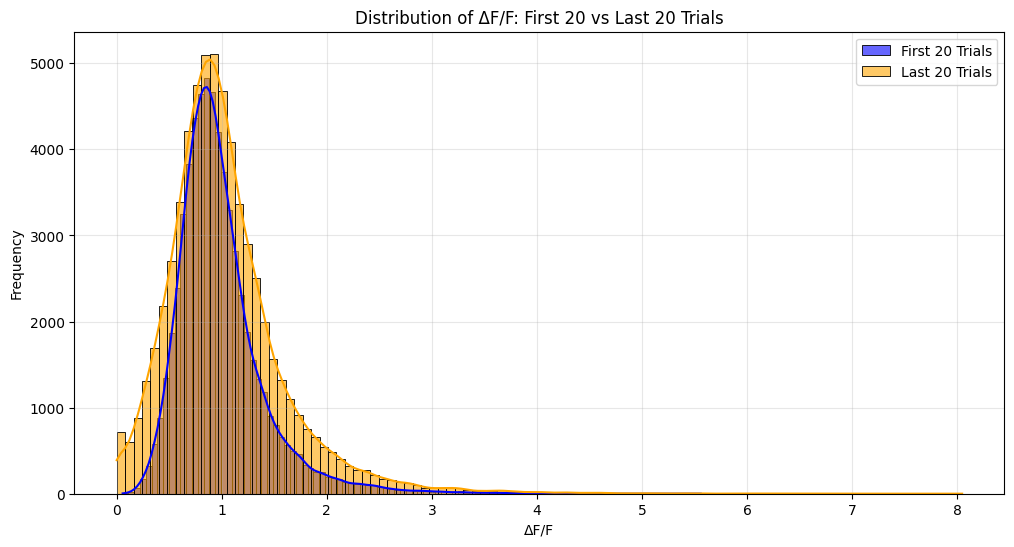

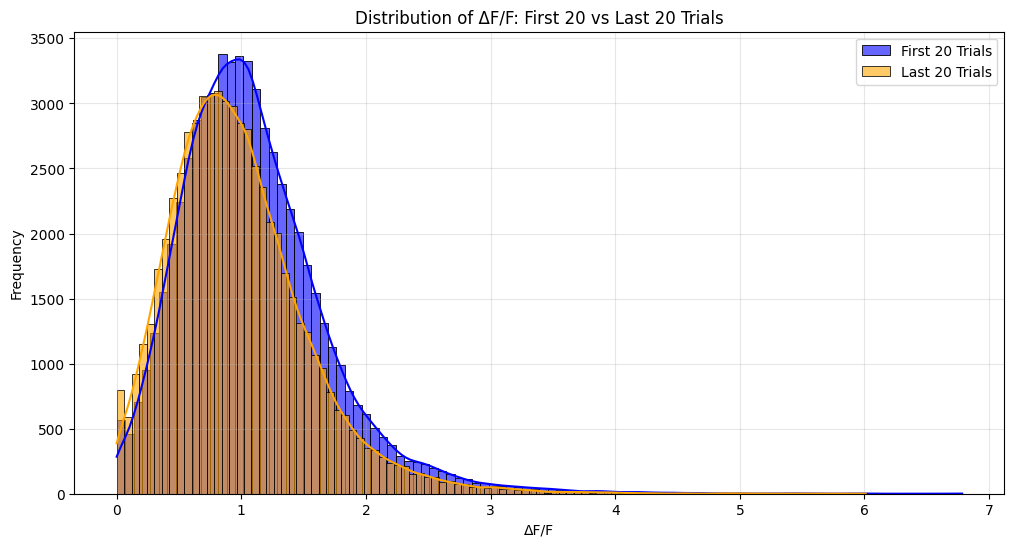

In [5]:
def plot_delta_f_over_f(mean_activity_cs, num_trials_to_compare=20, alpha_value=0.6):
    """
    Distribution of ΔF/F values for the first and last N trials of mean_activity_cs

    - mean_activity_cs: 2D numpy array (n_trials, n_neurons), trial-level fluorescence activity
    - num_trials_to_compare: int, number of trials to compare (default=20)
    - alpha_value: float, transparency level for the plot (default=0.6)"""

    n_trials, n_neurons = mean_activity_cs.shape

    # Select first and last N trials
    first_trials = mean_activity_cs[:num_trials_to_compare].flatten()
    last_trials = mean_activity_cs[-num_trials_to_compare:].flatten()

    # Plot the distribution using seaborn
    plt.figure(figsize=(12, 6))

    sns.histplot(first_trials, kde=True, color='blue', bins=100, alpha=alpha_value, label=f'First {num_trials_to_compare} Trials')
    sns.histplot(last_trials, kde=True, color='orange', bins=100, alpha=alpha_value, label=f'Last {num_trials_to_compare} Trials')

    plt.title(f'Distribution of ΔF/F: First {num_trials_to_compare} vs Last {num_trials_to_compare} Trials')
    plt.xlabel('ΔF/F')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



plot_delta_f_over_f(mean_activity_cs_1)
plot_delta_f_over_f(mean_activity_cs_2)
plot_delta_f_over_f(mean_activity_r_1)
plot_delta_f_over_f(mean_activity_r_2)

reacts = np.concatenate([mean_activity_r_1, mean_activity_r_2])
SERs = np.concatenate([mean_activity_cs_1, mean_activity_cs_2])

plot_delta_f_over_f(reacts)
plot_delta_f_over_f(SERs)


# Other, PCA

Reactivation data centered shape: (250, 3124)
SER data centered shape: (128, 3124)
Mean of centered reactivation data: [-1.57651669e-16 -6.27498054e-16 -6.75459688e-16 ...  4.26325641e-17
 -4.50306459e-16 -9.76996262e-18]
Mean of centered SER data: [ 1.82145965e-16 -9.54097912e-17  5.32560107e-16 ... -4.17200996e-16
 -3.24393290e-16 -3.20056481e-16]


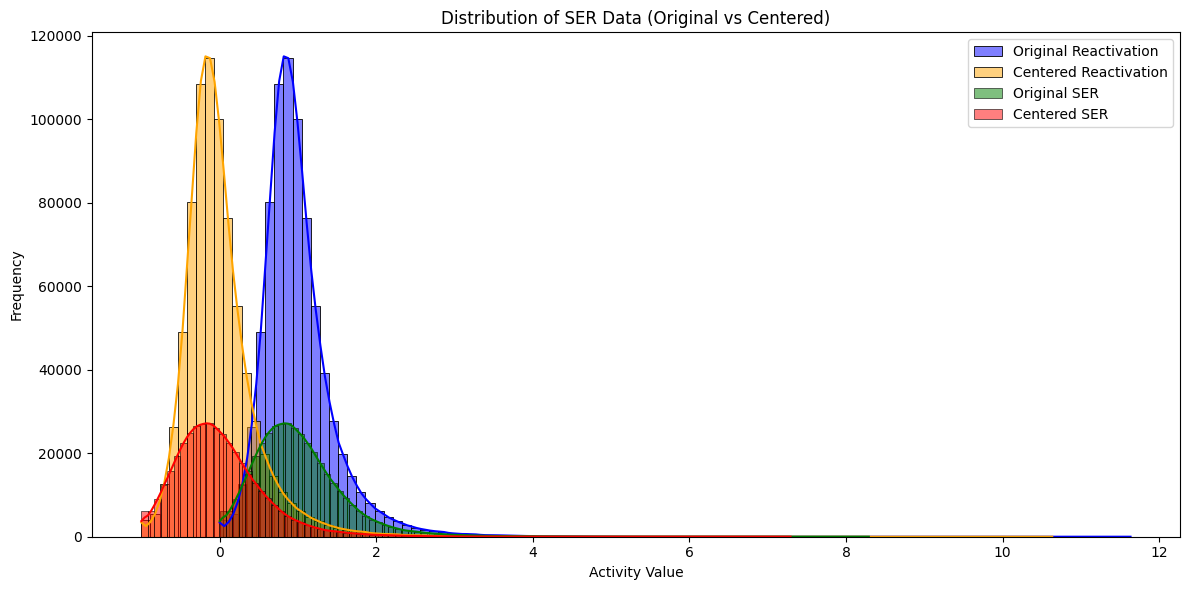

In [4]:
SERs = np.concatenate([mean_activity_cs_1, mean_activity_cs_2])
Reacts = np.concatenate([mean_activity_r_1, mean_activity_r_2])

def center_data(data):
    """
    Centers the data by subtracting the mean activity per neuron.

    Parameters:
    - data: 2D numpy array (trials/reactivations, neurons)

    Returns:
    - centered_data: 2D numpy array with mean-centered values
    - neuron_means: 1D array of mean values per neuron
    """

    # Compute mean activity for each neuron across all trials/reactivations
    neuron_means = np.mean(data, axis=0)  # Shape: (neurons,)

    # Subtract mean from each neuron's activity
    centered_data = data - neuron_means

    return centered_data, neuron_means


# Center the reactivation and SER data
reacts_centered, r_means = center_data(Reacts)
SER_centered, cs_means = center_data(SERs)

print("Reactivation data centered shape:", reacts_centered.shape)
print("SER data centered shape:", SER_centered.shape)

# Check if means are close to zero (should be near zero after centering)
print("Mean of centered reactivation data:", np.mean(reacts_centered, axis=0))
print("Mean of centered SER data:", np.mean(SER_centered, axis=0))

# Flatten the data for plotting
original_r_flat = Reacts.flatten()
centered_r_flat = reacts_centered.flatten()
original_cs_flat = SERs.flatten()
centered_cs_flat = SER_centered.flatten()

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot original vs centered reactivation data
sns.histplot(original_r_flat, bins=100, alpha=0.5, label='Original Reactivation', color='blue', kde=True)
sns.histplot(centered_r_flat, bins=100, alpha=0.5, label='Centered Reactivation', color='orange', kde=True)
plt.title("Distribution of Reactivation Data (Original vs Centered)")
plt.xlabel("Activity Value")
plt.ylabel("Frequency")
plt.legend()

# Plot original vs centered SER data
sns.histplot(original_cs_flat, bins=100, alpha=0.5, label='Original SER', color='green', kde=True)
sns.histplot(centered_cs_flat, bins=100, alpha=0.5, label='Centered SER', color='red', kde=True)
plt.title("Distribution of SER Data (Original vs Centered)")
plt.xlabel("Activity Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


PCA Analysis for Reactivation Data:


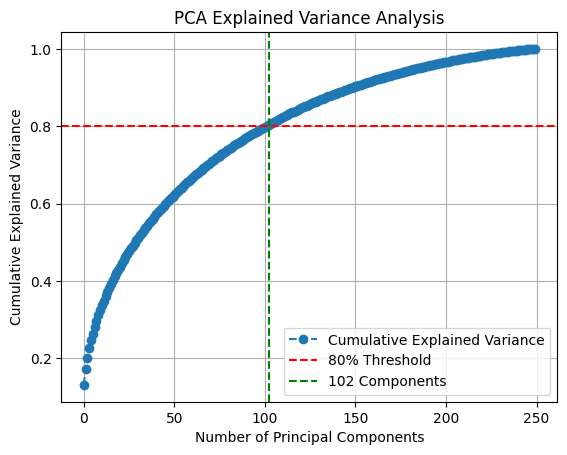

Number of components to explain 80% variance: 102

PCA Analysis for SER Data:


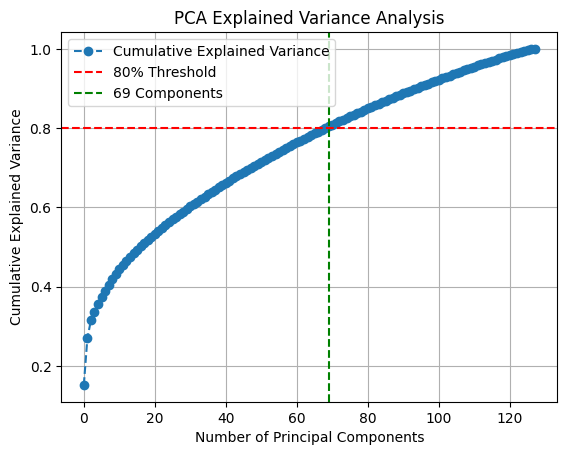

Number of components to explain 80% variance: 69
(250, 102) (128, 69)


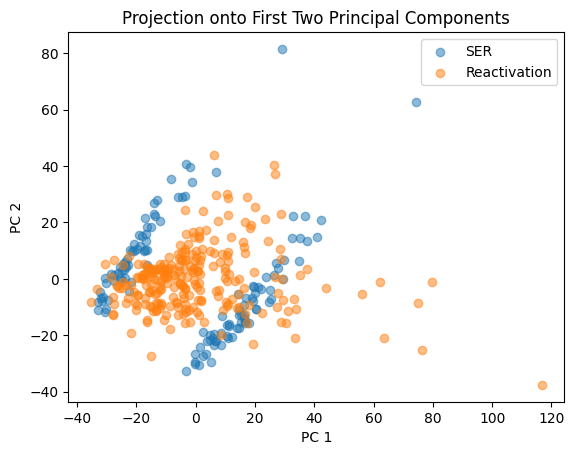

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to perform PCA and analyze explained variance
def perform_pca(data, explained_variance_threshold=0.80):
    """
    Performs PCA on the input data and determines the number of components 
    needed to explain the given variance threshold.

    Parameters:
    - data: 2D numpy array (samples, features)
    - explained_variance_threshold: float, target variance to explain 

    Returns:
    - pca: trained PCA object
    - num_components: number of components required to reach threshold
    """

    # Standardize the data 
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Fit PCA model
    pca = PCA()
    pca.fit(data_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components needed to explain desired variance
    num_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1

    # Project data onto top k principal components
    projected_data = pca.transform(data_scaled)[:, :num_components]

    # Plot explained variance ratio
    plt.plot(cumulative_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
    plt.axhline(y=explained_variance_threshold, color='r', linestyle='--', label=f'{explained_variance_threshold * 100:.0f}% Threshold')
    plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance Analysis')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Number of components to explain {explained_variance_threshold * 100:.0f}% variance: {num_components}")

    return pca, num_components, projected_data


# Perform PCA on reactivation data
print("PCA Analysis for Reactivation Data:")
pca_r, num_components_r, reactivation_projected = perform_pca(reacts_centered)

# Perform PCA on SER data
print("\nPCA Analysis for SER Data:")
pca_cs, num_components_cs, ser_projected = perform_pca(SER_centered)

print(reactivation_projected.shape, ser_projected.shape)

plt.scatter(ser_projected[:, 0], ser_projected[:, 1], alpha=0.5, label="SER")
plt.scatter(reactivation_projected[:, 0], reactivation_projected[:, 1], alpha=0.5, label="Reactivation")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("Projection onto First Two Principal Components")
plt.show()


(139, 3124)
PCA Analysis for Reactivation Data:


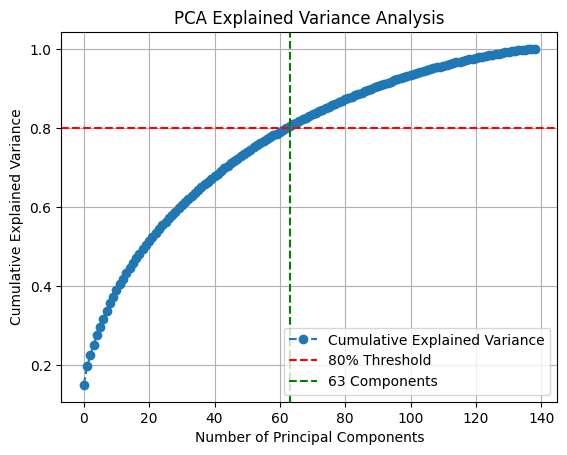

Number of components to explain 80% variance: 63

PCA Analysis for SER Data:


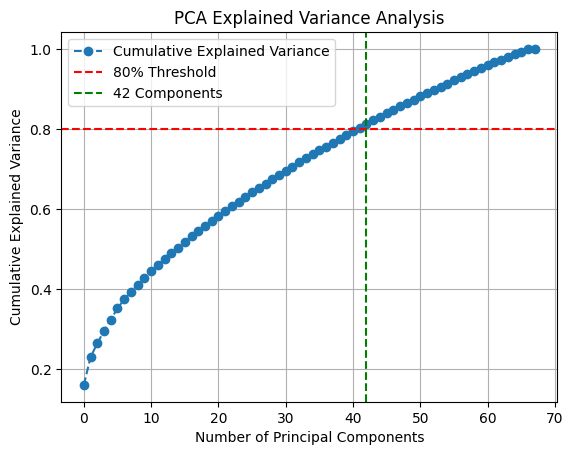

Number of components to explain 80% variance: 42
PCA Analysis for Reactivation Data:


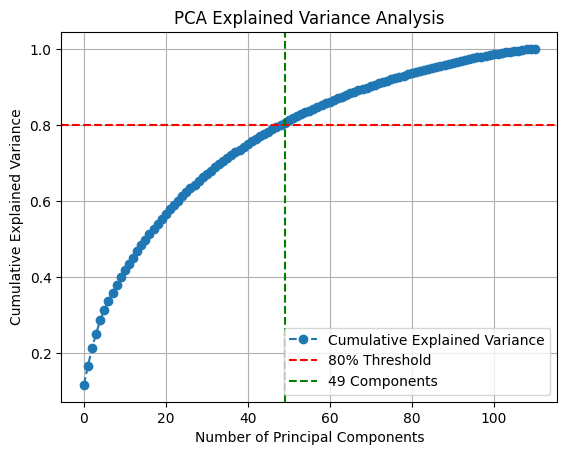

Number of components to explain 80% variance: 49

PCA Analysis for SER Data:


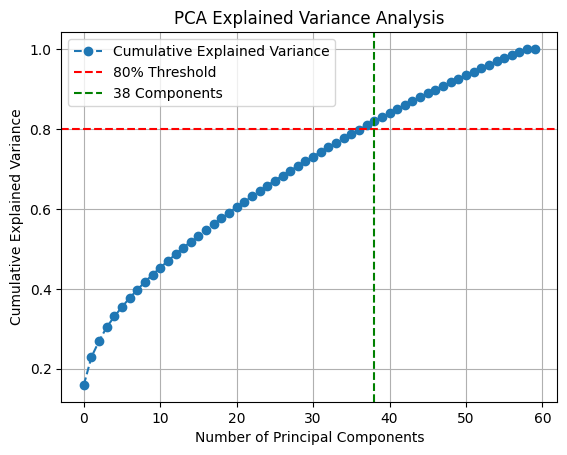

Number of components to explain 80% variance: 38


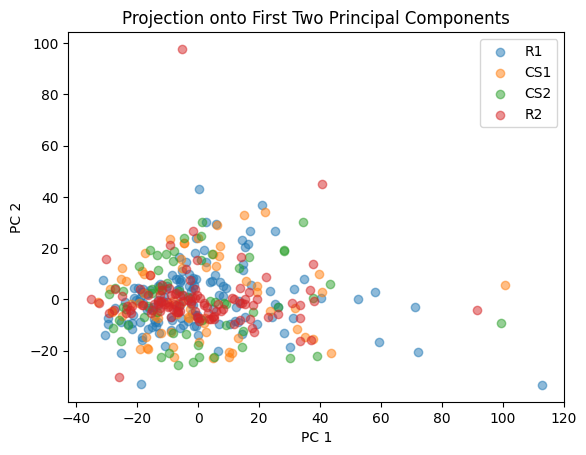

In [ ]:
r1_centered, r1_means = center_data(mean_activity_r_1)
cs1_centered, cs1_means = center_data(mean_activity_cs_1)
r2_centered, r2_means = center_data(mean_activity_r_2)
cs2_centered, cs2_means = center_data(mean_activity_cs_2)


print(r1_centered.shape)

print("PCA Analysis for Reactivation Data:")
pca_r_1, num_components_r_1, r1_projected = perform_pca(r1_centered)

# Perform PCA on SER data
print("\nPCA Analysis for SER Data:")
pca_cs_1, num_components_cs_1, cs1_projected = perform_pca(cs1_centered)

print("PCA Analysis for Reactivation Data:")
pca_r_2, num_components_r_2, r2_projected = perform_pca(r2_centered)

# Perform PCA on SER data
print("\nPCA Analysis for SER Data:")
pca_cs_2, num_components_cs_2, cs2_projected = perform_pca(cs2_centered)

plt.scatter(r1_projected[:, 0], r1_projected[:, 1], alpha=0.5, label="R1")
plt.scatter(cs1_projected[:, 0], cs1_projected[:, 1], alpha=0.5, label="CS1")
plt.scatter(cs2_projected[:, 0], cs2_projected[:, 1], alpha=0.5, label="CS2")
plt.scatter(r2_projected[:, 0], r2_projected[:, 1], alpha=0.5, label="R2")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("Projection onto First Two Principal Components")
plt.show()



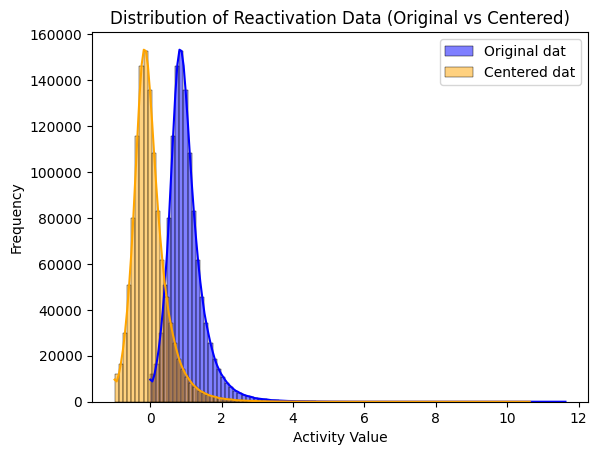

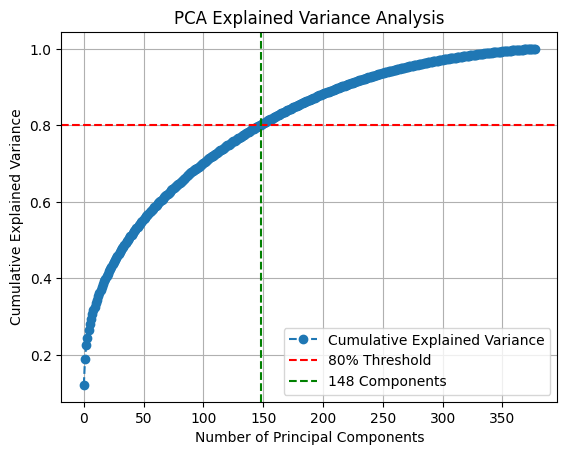

Number of components to explain 80% variance: 148


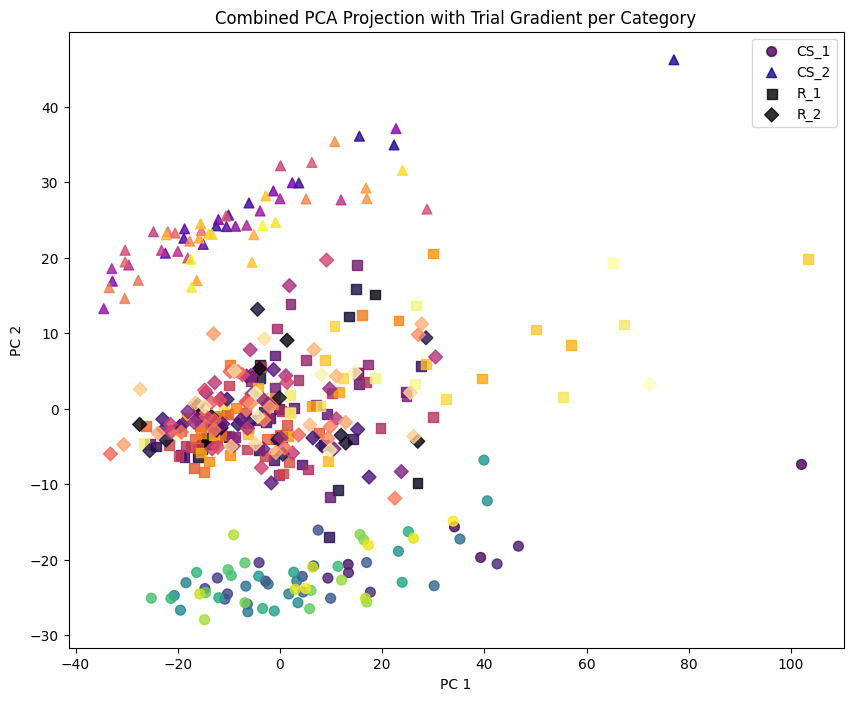

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Concatenate the arrays (each of shape: (trials, neurons))
all_dat = np.concatenate([mean_activity_cs_1, mean_activity_cs_2, mean_activity_r_1, mean_activity_r_2], axis=0)
centered_dat, means_dat = center_data(all_dat)

# Flatten the data for histogram plotting
original_dat_flat = all_dat.flatten()
centered_dat_flat = centered_dat.flatten()

# Plot original vs centered data distributions
sns.histplot(original_dat_flat, bins=100, alpha=0.5, label='Original dat', color='blue', kde=True)
sns.histplot(centered_dat_flat, bins=100, alpha=0.5, label='Centered dat', color='orange', kde=True)
plt.title("Distribution of Reactivation Data (Original vs Centered)")
plt.xlabel("Activity Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Here, projected_data should be of shape (n_trials, n_components)
pca_r, num_components_r, reactivation_projected = perform_pca(centered_dat)

labels = (['CS_1'] * mean_activity_cs_1.shape[0] +
          ['CS_2'] * mean_activity_cs_2.shape[0] +
          ['R_1']  * mean_activity_r_1.shape[0] +
          ['R_2']  * mean_activity_r_2.shape[0])

trial_orders = []
start_idx = 0
for d in [mean_activity_cs_1, mean_activity_cs_2, mean_activity_r_1, mean_activity_r_2]:
    n = d.shape[0]
    # Create a trial gradient for this category (values between 0 and 1)
    trial_orders.extend(np.linspace(0, 1, n))
    start_idx += n
trial_orders = np.array(trial_orders)

unique_cats = ['CS_1', 'CS_2', 'R_1', 'R_2']
color_dict = {'CS_1': sns.color_palette("viridis", as_cmap=True),
              'CS_2': sns.color_palette("plasma", as_cmap=True),
              'R_1': sns.color_palette("inferno", as_cmap=True),
              'R_2': sns.color_palette("magma", as_cmap=True)}
marker_dict = {'CS_1': 'o', 'CS_2': '^', 'R_1': 's', 'R_2': 'D'}

plt.figure(figsize=(10,8))
# We iterate over each category and plot points belonging to that category.
start = 0
for cat, d in zip(unique_cats, [mean_activity_cs_1, mean_activity_cs_2, mean_activity_r_1, mean_activity_r_2]):
    n = d.shape[0]
    # Get indices corresponding to this category:
    idx = np.arange(start, start+n)
    # For the color gradient, we map the trial order for this category:
    trial_grad = trial_orders[idx]
    sc = plt.scatter(reactivation_projected[idx, 0], reactivation_projected[idx, 1],
                     c=trial_grad, cmap=color_dict[cat],
                     marker=marker_dict[cat], s=50, alpha=0.8, label=cat)
    # Optionally, add a colorbar for each category.
    # For simplicity, here we only add one common colorbar.
    start += n

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Combined PCA Projection with Trial Gradient per Category")
plt.legend()
plt.show()


# UMAP

umap_embedding_reac shape: (250, 102)
Number of labels: 250


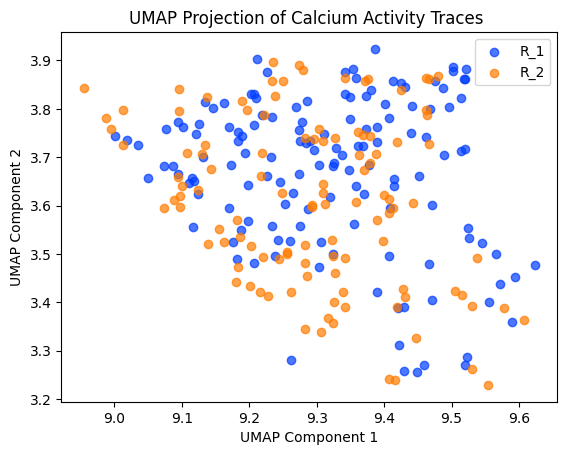

In [60]:
import umap.umap_ as umap

#UMAP on reactivations only
umap_model_reac = umap.UMAP(n_components=102, random_state=42)
umap_embedding_reac = umap_model_reac.fit_transform(Reacts)

labels_r = (['R_1']  * mean_activity_r_1.shape[0] +
          ['R_2']  * mean_activity_r_2.shape[0])

palette = sns.color_palette("bright", 2)
color_dict_r = {'R_1': palette[0],  'R_2': palette[1]}

print("umap_embedding_reac shape:", umap_embedding_reac.shape)
print("Number of labels:", len(labels_r))


for cat in np.unique(labels_r):
    idx = [i for i, lab in enumerate(labels_r) if lab == cat]
    plt.scatter(umap_embedding_reac[idx, 0], umap_embedding_reac[idx, 1],
                color=color_dict_r[cat], label=cat, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Calcium Activity Traces ')
plt.legend()
plt.show()


umap_embedding_reac shape: (128, 69)
Number of labels: 128


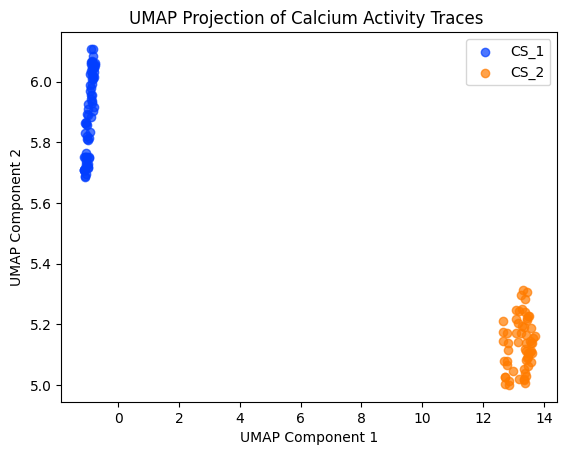

In [59]:
#UMAP on SERs only
umap_model_ser = umap.UMAP(n_components=69, random_state=42)
umap_embedding_ser = umap_model_ser.fit_transform(SERs)

labels_cs = (['CS_1']  * mean_activity_cs_1.shape[0] +
          ['CS_2']  * mean_activity_cs_2.shape[0])

palette = sns.color_palette("bright", 4)
color_dict_cs = {'CS_1': palette[0], 'CS_2': palette[1]}


print("umap_embedding_reac shape:", umap_embedding_ser.shape)
print("Number of labels:", len(labels_cs))


for cat in np.unique(labels_cs):
    idx = [i for i, lab in enumerate(labels_cs) if lab == cat]
    plt.scatter(umap_embedding_ser[idx, 0], umap_embedding_ser[idx, 1],
                color=color_dict_cs[cat], label=cat, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Calcium Activity Traces ')
plt.legend()
plt.show()

umap_embedding_reac shape: (250, 102)
Number of labels: 378


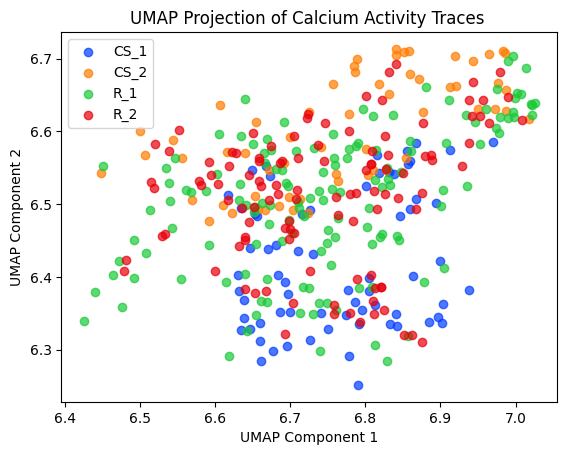

In [55]:
#UMAP on all data
umap_model_ser = umap.UMAP(n_components=148, random_state=42)
umap_embedding_ser = umap_model_ser.fit_transform(all_dat)

labels_cs = (['CS_1']  * mean_activity_cs_1.shape[0] +
          ['CS_2']  * mean_activity_cs_2.shape[0] +
            ['R_1']  * mean_activity_r_1.shape[0] +
          ['R_2']  * mean_activity_r_2.shape[0])

palette = sns.color_palette("bright", 4)
color_dict_cs = {'CS_1': palette[0], 'CS_2': palette[1], 
                 'R_1': palette[2],  'R_2': palette[3]}


print("umap_embedding_reac shape:", umap_embedding_reac.shape)
print("Number of labels:", len(labels_cs))


for cat in np.unique(labels_cs):
    idx = [i for i, lab in enumerate(labels_cs) if lab == cat]
    plt.scatter(umap_embedding_ser[idx, 0], umap_embedding_ser[idx, 1],
                color=color_dict_cs[cat], label=cat, alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Calcium Activity Traces ')
plt.legend()
plt.show()

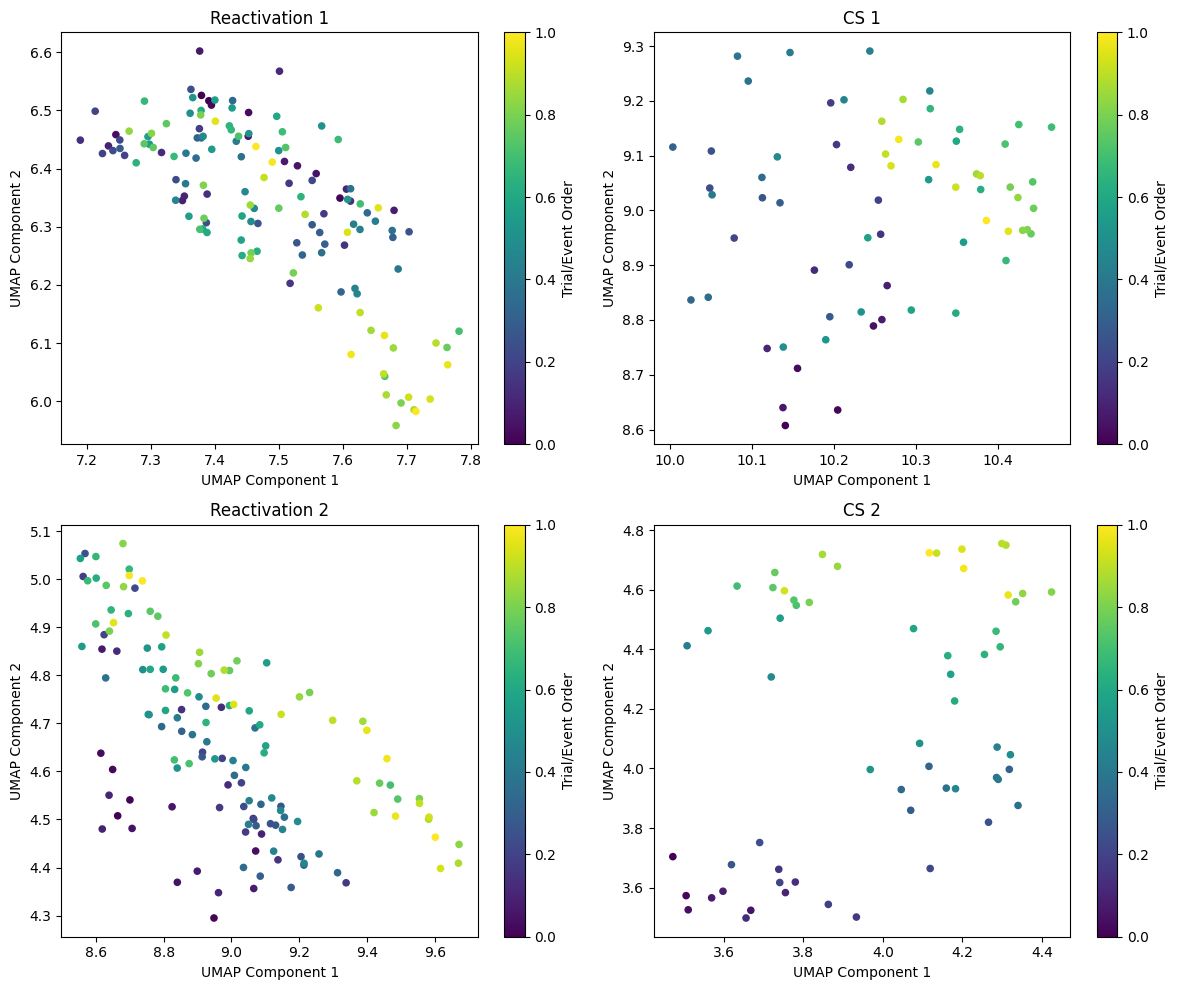

In [65]:
#UMAP per category

umap_model_r_1 = umap.UMAP(n_components=63, random_state=42)
umap_embedding_r_1  = umap_model_r_1.fit_transform(mean_activity_r_1)

umap_model_cs_1 = umap.UMAP(n_components=42, random_state=42)
umap_embedding_cs_1 = umap_model_cs_1.fit_transform(mean_activity_cs_1)

umap_model_r_2 = umap.UMAP(n_components=49, random_state=42)
umap_embedding_r_2 = umap_model_r_2.fit_transform(mean_activity_r_1)

umap_model_cs_2 = umap.UMAP(n_components=38, random_state=42)
umap_embedding_cs_2 = umap_model_cs_2.fit_transform(mean_activity_cs_2)

def scatter_with_gradient(embedding, title, ax):
    n = embedding.shape[0]
    # Create an array for the trial/event order
    trial_order = np.linspace(0, 1, n)
    # Create a scatter plot with color gradient based on trial/event order
    sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=trial_order, cmap='viridis', s=20)
    ax.set_title(title)
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    # Add a colorbar to indicate trial/event order
    plt.colorbar(sc, ax=ax, label='Trial/Event Order')

# Create a 2x2 grid for separate plots
fig, axes = plt.subplots(2, 2, figsize=(12,10))

scatter_with_gradient(umap_embedding_r_1, "Reactivation 1", axes[0, 0])
scatter_with_gradient(umap_embedding_cs_1, "CS 1", axes[0, 1])
scatter_with_gradient(umap_embedding_r_2, "Reactivation 2", axes[1, 0])
scatter_with_gradient(umap_embedding_cs_2, "CS 2", axes[1, 1])

plt.tight_layout()
plt.show()



